In [ ]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import cv2
import random

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torchvision.datasets import FashionMNIST

# __________end of block__________

Продолжим работать с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist).

__Ваша задача: реализовать механизм выделения границ (Sobel filter) и упрощенный вариант построения гистограммы ориентированных градиентов.__

Точность классификации оцениваться не будет, вам лишь необходимо реализовать функции и сдать их в контест.

В ноутбуке присутствует несколько тестов, которые помогут вам отладить свое решение.

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.67MB/s]


Text(0.5, 1.0, 'Image label: 4')

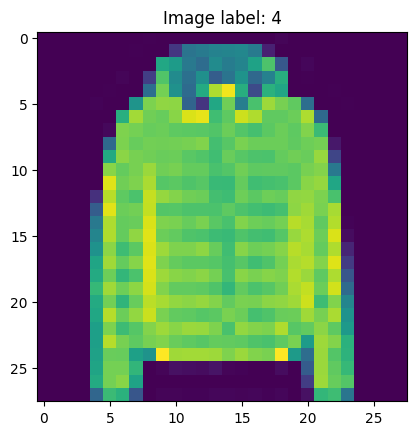

In [ ]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)

train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

#### Шаг 1. Sobel filtering
Реализуйте функцию `compute_sobel_gradients_two_loops`. Часть функции уже написана, пожалуйста, не меняйте написанный код.

In [ ]:
# do not change the code in the block below
# __________start of block__________
import numpy as np
def compute_sobel_gradients_two_loops(image):
    # Get image dimensions
    height, width = image.shape

    # Initialize output gradients
    gradient_x = np.zeros_like(image, dtype=np.float64)
    gradient_y = np.zeros_like(image, dtype=np.float64)

    # Pad the image with zeros to handle borders
    padded_image = np.pad(image, ((1, 1), (1, 1)), mode='constant', constant_values=0)
# __________end of block__________

    # Define the Sobel kernels for X and Y gradients
    sobel_x = np.array([[-1,0,1],  [-2,0,2], [-1, 0 , 1]] ) # YOUR CODE HERE
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]) # YOUR CODE HERE

    # Apply Sobel filter for X and Y gradients using convolution
    for i in range(1, height + 1):
        for j in range(1, width + 1):
            gradient_x[i-1,j-1] = sum(np.multiply(padded_image[i-1:i+2, j-1:j+2],sobel_x).flatten())
            gradient_y[i-1,j-1] = sum(np.multiply(padded_image[i-1:i+2, j-1:j+2],sobel_y).flatten())
            # YOUR CODE HERE
    return gradient_x, gradient_y

Для проверки написанного кода мы обратимся к уже реализованной версии в из opencv. Ввиду того, что операция padding'а может произвоиться иначе, будем игнорировать расхождения на краях изображения.

In [ ]:
# do not change the code in the block below
# __________start of block__________
def compute_sobel_gradients_opencv(image):
    # Apply Sobel filter for horizontal and vertical gradients
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Return gradients in both directions
    return sobel_x, sobel_y
# __________end of block__________


In [ ]:
# do not change the code in the block below
# __________start of block__________
image = train_fmnist_data[7][0][0].numpy()
gradients_two_loops = compute_sobel_gradients_two_loops(image)
gradients_opencv = compute_sobel_gradients_opencv(image)

assert np.allclose(gradients_two_loops[0][1:-1, 1:-1], gradients_opencv[0][1:-1, 1:-1], atol=1e-2), "gradients_two_loops[0] and gradients_opencv[0] are not close"
assert np.allclose(gradients_two_loops[1][1:-1, 1:-1], gradients_opencv[1][1:-1, 1:-1], atol=1e-2), "gradients_two_loops[1] and gradients_opencv[1] are not close"
print("Everything seems fine!")
# __________end of block__________


Everything seems fine!


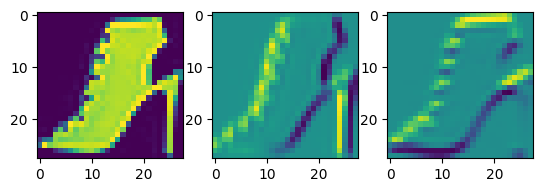

In [ ]:
image = random.choice(train_fmnist_data)[0][0].numpy()
gradients_two_loops = compute_sobel_gradients_two_loops(image)

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(gradients_two_loops[0])
plt.subplot(1, 3, 3)
plt.imshow(gradients_two_loops[1])

#### Шаг 2. Подсчет градиентов в полярных координатах.
Реализуйте две функции:
 * `compute_gradient_magnitude`, котрая считает евклидову норму градиента
 * `compute_gradient_direction`, которая счиает его направление в виде угла относительно оси $x$. Возвращаемый угол должен быть в диапазоне $(-180; 180]$.

In [ ]:
import numpy as np # for your convenience when you copy the code to the contest
def compute_gradient_magnitude(sobel_x, sobel_y):
    '''
    Compute the magnitude of the gradient given the x and y gradients.

    Inputs:
        sobel_x: numpy array of the x gradient.
        sobel_y: numpy array of the y gradient.

    Returns:
        magnitude: numpy array of the same shape as the input [0] with the magnitude of the gradient.
    '''
    # YOUR CODE HERE
    return   np.hypot(sobel_x,sobel_y) #np.sqrt(np.power(sobel_x,2) + np.power(sobel_y,2))


def compute_gradient_direction(sobel_x,sobel_y):
    '''
    Compute the direction of the gradient given the x and y gradients. Angle must be in degrees in the range (-180; 180].
    Use arctan2 function to compute the angle.

    Inputs:
        sobel_x: numpy array of the x gradient.
        sobel_y: numpy array of the y gradient.

    Returns:
        gradient_direction: numpy array of the same shape as the input [0] with the direction of the gradient.
    '''
    # YOUR CODE HERE
    return np.arctan2(sobel_y,sobel_x)* 180 / np.pi


Небольшие тесты для функции `compute_gradient_direction`

In [ ]:
# do not change the code in the block below
# __________start of block__________
image = train_fmnist_data[7][0][0].numpy()
gradients_two_loops = compute_sobel_gradients_two_loops(image)

magnitudes = compute_gradient_magnitude(gradients_two_loops[0], gradients_two_loops[1])
angles = compute_gradient_direction(gradients_two_loops[0], gradients_two_loops[1])
assert np.all(magnitudes >= 0), "Magnitudes should be non-negative"
assert np.all(angles > -180) and np.all(angles <= 180), "Angles should be in the range (-180, 180]"
print("Everything seems fine!")
# __________end of block__________


Everything seems fine!


Пример визуализации итоговых границ, полученных с помощью фильтра Собеля:

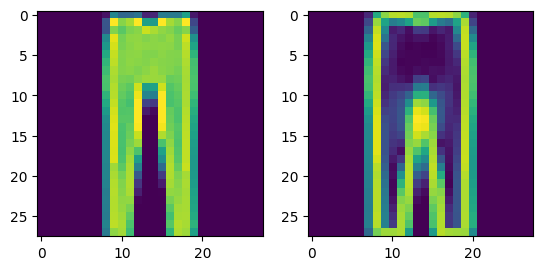

In [ ]:
image = random.choice(train_fmnist_data)[0][0].numpy()
magnitudes = compute_gradient_magnitude(*compute_sobel_gradients_two_loops(image))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(magnitudes)

#### Шаг 3. Упрощённый вариант HoG.
Вам предстоит реализовать гистограмму ориентированных градиентов (HoG). В общем виде это происходит следующим образом:
1. Перевод изображения в одноканальное. Если изображение цветное, то оно долнжо быть преобразовано в оттенки серого. Можно воспользоваться формулой из [Wiki](https://en.wikipedia.org/wiki/Grayscale):
$$
\text{brightness}_{i, j} = \text{Red}_{i, j} * 0.2126 + \text{Green}_{i, j} * 0.7152 + \text{Blue}_{i, j} * 0.0722,
$$
но для простоты просто будем усреднять все каналы.

*Примечание: это далеко не единственный способ преобразования, и он может быть нелинейным. Подробности доступны по ссылке выше*.

2. Вычисление градиентов изображения с помощью фитра Собеля.

3. Определение направления и нормы градиента для каждого пикселя.

4. Построение гистограмм направлений градиентов. Для этого изображение разбивается на непересекающиеся квадратные ячейки. Размер каждой ячейки задается параметром `pixels_per_cell`, который по умолчанию равен равным `(cell_size, cell_size)`, параметр `cell_size` задан по умолчанию ниже в коде. Для каждой ячейки изображения строится гистограмму направлений градиентов. Для этого:
    * Каждое направление градиента будет отнесено к определенному бину (всего 9 бинов от -180 до 180).
    * Для каждого бина все попавшие в нее нормы суммируются.
    * Построенная гистограмма нормируется (чтобы сумма всех бинов была равна 1).
    * *Примечание: рекомендуем использовать `np.histogram` для получения результатов, где совпадают краевые значения. Т.к. элементы положительные, нормировка производится на их общую сумму, если гистограмма не пустая.*
5. Групповая нормализация гистограмм. Для большей адаптивности метода к изменениям освещенности производится нормировка. Подробнее о ней можно почитать [здесь](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html). В данном задании она производиться **не будет**.

На этом этапе вам нужно выполнить только шаги 1-4. Обратите внимание, что **групповая нормализация** гистограмм не выполняется (этот шаг пропущен).

In [ ]:
def compute_hog(image, pixels_per_cell=(7, 7), bins=9):
    # 1. Convert the image to grayscale if it's not already (assuming the image is in RGB or BGR)
    if len( image.shape ) == 3:
        image = np.mean( image, axis=2 )  # Simple averaging to convert to grayscale

    #pad_image = np.pad( image, ((1, 1), (1, 1)), mode='constant', constant_values=0 )
    # 2. Compute gradients with Sobel filter

    gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # YOUR CODE HERE
    gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    # 3. Compute gradient magnitude and direction
    magnitude = np.sqrt(np.power(gx,2) + np.power(gy,2))
    direction = np.degrees(np.arctan2(gy, gx))
    direction[ direction == -180 ] = 180
    direction = np.nan_to_num( direction, nan=0.0, posinf=0.0, neginf=0.0 )

    # 4. Create histograms of gradient directions for each cell
    cell_height, cell_width = pixels_per_cell
    n_cells_x = image.shape[ 1 ] // cell_width
    n_cells_y = image.shape[ 0 ] // cell_height

    histograms = np.zeros( (n_cells_y, n_cells_x, bins) )
    bin_edges = np.linspace(-180, 180, bins + 1, endpoint=True )

    for i in range( n_cells_y ):
        for j in range( n_cells_x ):
            # Извлекаем ячейку
            y_start, y_end = i * cell_height, (i + 1) * cell_height
            x_start, x_end = j * cell_width, (j + 1) * cell_width
            dir_patch = direction[ y_start:y_end, x_start:x_end ].flatten( )
            mag_patch = magnitude[ y_start:y_end, x_start:x_end ].flatten( )

            # Вычисляем гистограмму с весами (магнитудами)
            hist, _ = np.histogram( dir_patch, bins=bin_edges, weights=mag_patch,density = True )

            histograms[ i, j ] = hist / (np.sum( hist ) + 1e-6)
    return histograms

Для запуска тестов ниже файлы `hog_data.npy` и `image_data.npy` из репозитория должны быть доступны в той же директории, что и ноутбук. Вы можете скачать их в репозитории.

In [ ]:
# do not change the code in the block below
# __________start of block__________
image = random.choice(train_fmnist_data)[0][0].numpy()

hog = compute_hog(image)
assert hog.shape == (4, 4, 9), "hog should have shape (4, 4, 9) for the FashionMNIST image with default parameters"
print("Everything seems fine!")

assert os.path.exists("hog_data.npy") and os.path.exists("image_data.npy"), "hog_data.npy and image_data.npy should be in the same directory as the notebook"
with open("hog_data.npy", "rb") as f:
    hog_data = np.load(f, allow_pickle=True)
with open("image_data.npy", "rb") as f:
    image_data = np.load(f, allow_pickle=True)
for test_image, test_hog in zip(image_data, hog_data):
    hog = compute_hog(test_image)
    assert np.allclose(hog, test_hog), "hog should be the same"

# __________end of block__________


Everything seems fine!


/usr/local/lib/python3.11/dist-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


AssertionError: hog should be the same

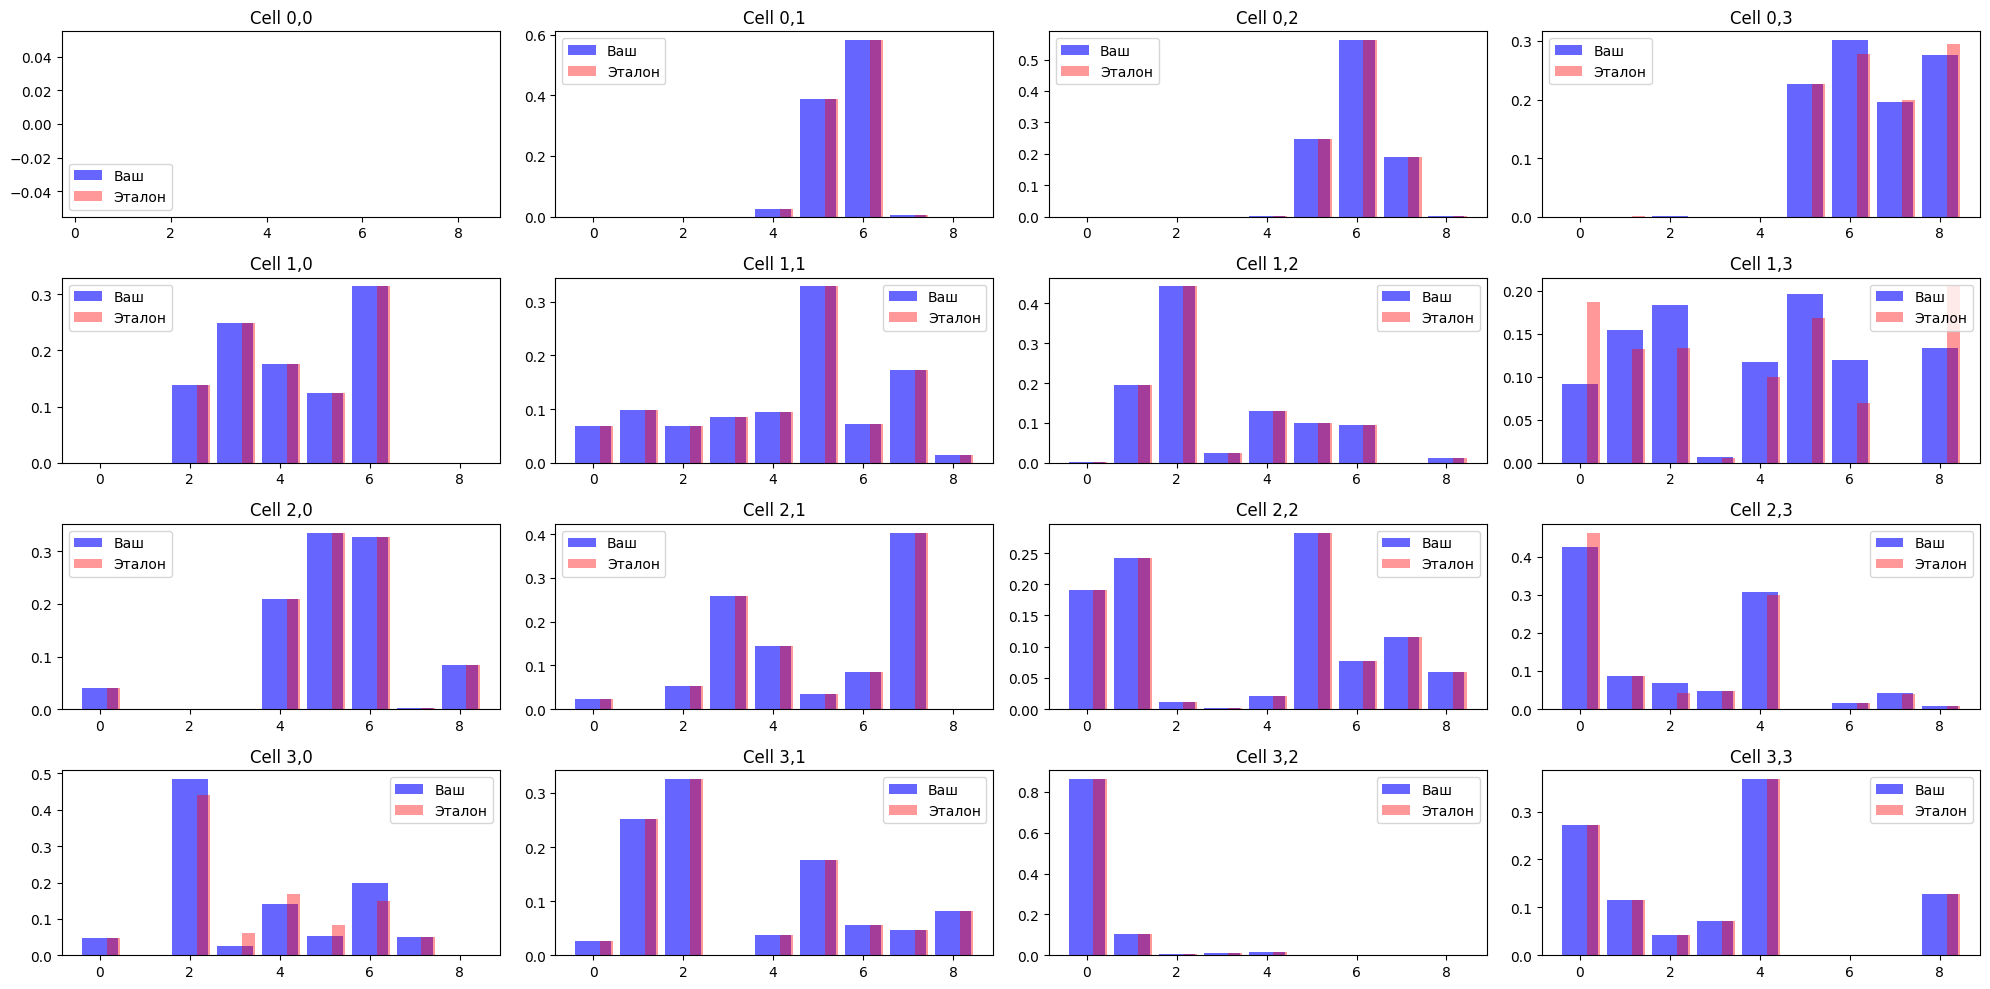

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(20, 10))  # 4 строки, 4 столбца

for i in range(4):
    for j in range(4):
        # Левый график (ваш HOG)
        ax1 = axes[i, j]
        ax1.bar(range(len(hog[i, j])), hog[i, j], color='blue', alpha=0.6, label='Ваш')

        # Правый график (эталонный HOG) - смещаем столбцы
        ax1.bar(np.arange(len(test_hog[i, j])) + 0.3, test_hog[i, j],
                color='red', alpha=0.4, width=0.3, label='Эталон')

        ax1.set_title(f"Cell {i},{j}")
        ax1.legend()

plt.tight_layout()
plt.show()

### Сдача задания
Сдайте функции в задачу в соревновании. Не забудьте, что при вставке кода все импортируемые библиотеки также должны вставляться вместе с вашим кодом. Вы не должны использовать что-либо, кроме `numpy` при написании решения.

На этом задание завершено. Поздравляем!